In [ ]:
# NOTES

# We are working on Bandwidth prediction model
# our data is "ts" -> time in epcoh , "bandwidth" -> in bits per sec
# We have sourced this subset of data internally
# cleanse the data where possible
# there are some data holes, which are the issue of collection, which you will see is reflected in visualization graph
# as we proceed we are working with Data collection team to address them where ever possible


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

% matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 8.0)
pd.set_option('display.precision',9)

In [80]:
bw = pd.read_csv('./bw_data.csv')
bw.head()
# you will notice that data is not sorted out, we will do that in below steps

,id,ts,bandwidth
0,4,1518575533,56623520
1,5,1518575240,95733424
2,6,1518572471,52946496
3,7,1518576880,61887376
4,8,1518579103,48975776


In [81]:
bw.drop(columns=['id'], inplace=True)

In [82]:
bw.dtypes

ts           object
bandwidth    object
dtype: object

In [83]:
bw.isnull().sum()

ts           0
bandwidth    0
dtype: int64

In [84]:
bw.shape

(918792, 2)

In [85]:
bw = bw[bw.loc[:, 'ts'] != 'ts']
bw.shape
## 19 rows has invalid values. Contains: word "ts" instead of timestamps and "bandwidth" instead of bandwidth value
## remove it

(918773, 2)

In [86]:
bw.loc[:, 'bandwidth'] = pd.to_numeric(bw.loc[:, 'bandwidth'], errors='coerce')

In [87]:
bw.shape

(918773, 2)

In [88]:
bw.dtypes

ts           object
bandwidth     int64
dtype: object

In [89]:
bw.isnull().sum()


ts           0
bandwidth    0
dtype: int64

In [90]:
bw.head()

,ts,bandwidth
0,1518575533,56623520
1,1518575240,95733424
2,1518572471,52946496
3,1518576880,61887376
4,1518579103,48975776


In [91]:
bw.head()

,ts,bandwidth
0,1518575533,56623520
1,1518575240,95733424
2,1518572471,52946496
3,1518576880,61887376
4,1518579103,48975776


In [92]:
bw['ts'] = pd.to_datetime(bw['ts'], unit='s', utc=True)

## Add Missing Values

In [93]:
bw.head()

,ts,bandwidth
0,2018-02-14 02:32:13+00:00,56623520
1,2018-02-14 02:27:20+00:00,95733424
2,2018-02-14 01:41:11+00:00,52946496
3,2018-02-14 02:54:40+00:00,61887376
4,2018-02-14 03:31:43+00:00,48975776


In [94]:
bw.sort_values(by=['ts'], inplace=True)

In [95]:
bw.head()

,ts,bandwidth
750218,2018-02-06 17:58:49+00:00,3270224
750217,2018-02-06 17:58:50+00:00,63710864
750246,2018-02-06 17:58:51+00:00,66147616
750197,2018-02-06 17:58:52+00:00,82064232
750179,2018-02-06 17:58:53+00:00,245525168


In [102]:
bw['diff_ts'] = bw['ts'].diff().shift(-1)

In [105]:
bw['diff_ts'] = bw['diff_ts'].dt.total_seconds()

In [106]:
bw.head()

,ts,bandwidth,diff_ts
750218,2018-02-06 17:58:49+00:00,3270224,1.0
750217,2018-02-06 17:58:50+00:00,63710864,1.0
750246,2018-02-06 17:58:51+00:00,66147616,1.0
750197,2018-02-06 17:58:52+00:00,82064232,1.0
750179,2018-02-06 17:58:53+00:00,245525168,1.0


In [135]:
bw.set_index('ts', inplace=True)
bw.head()

,bandwidth,diff_ts
ts,,
2018-02-06 17:58:49+00:00,3270224,1.0
2018-02-06 17:58:50+00:00,63710864,1.0
2018-02-06 17:58:51+00:00,66147616,1.0
2018-02-06 17:58:52+00:00,82064232,1.0
2018-02-06 17:58:53+00:00,245525168,1.0


In [204]:
list_with_filled_missing_data = []
# note logic is to check if diff in forward timestamp is greater than 1 sec
# if yes, then add that sec and copy previous bandwidth value to it
for tstamp, row in bw.iterrows():
    list_with_filled_missing_data.append([tstamp, int(row['bandwidth'])])
    if row['diff_ts'] > 1.0:
        start_date = tstamp
        for fill_ts in (start_date + pd.Timedelta(n, unit='s') for n in range(1, int(row['diff_ts']))):
            list_with_filled_missing_data.append([fill_ts, int(row['bandwidth'])])
bw_with_add_missing_ts_values = pd.DataFrame(list_with_filled_missing_data, columns=['ts','bandwidth'])
bw_with_add_missing_ts_values.head()

,ts,bandwidth
0,2018-02-06 17:58:49+00:00,3270224
1,2018-02-06 17:58:50+00:00,63710864
2,2018-02-06 17:58:51+00:00,66147616
3,2018-02-06 17:58:52+00:00,82064232
4,2018-02-06 17:58:53+00:00,245525168


In [207]:
bw.shape

(918773, 2)

In [205]:
bw_with_add_missing_ts_values.shape

(1984447, 2)

In [208]:
# verify if we now have data at 1 sec interval
bw_with_add_missing_ts_values['diff_ts'] = bw_with_add_missing_ts_values['ts'].diff().shift(-1)

In [209]:
bw_with_add_missing_ts_values['diff_ts'] = bw_with_add_missing_ts_values['diff_ts'].dt.total_seconds()

In [211]:
bw_with_add_missing_ts_values[(bw_with_add_missing_ts_values.diff_ts > 1.0)]

,ts,bandwidth,diff_ts


In [214]:
# As we have verified that all the timestamp we have is with 1 sec interval, thus dropping column 'diff_ts'
bw_with_add_missing_ts_values.drop('diff_ts', axis=1, inplace=True) 

In [215]:
# sorting
bw_with_add_missing_ts_values.sort_values(by=['ts'], inplace=True)

In [216]:
# indexing 'ts' column
bw_with_add_missing_ts_values.set_index('ts', inplace=True)
bw_with_add_missing_ts_values.head()

,bandwidth
ts,
2018-02-06 17:58:49+00:00,3270224
2018-02-06 17:58:50+00:00,63710864
2018-02-06 17:58:51+00:00,66147616
2018-02-06 17:58:52+00:00,82064232
2018-02-06 17:58:53+00:00,245525168


In [217]:
# persisting data from this frame to csv 
bw_with_add_missing_ts_values.to_csv('bw_cleaned_data.csv', encoding='utf-8')

In [18]:
bw.describe()['bandwidth'].apply(lambda x: '{:.2f}'.format(x))

count        918773.00
mean       60279311.74
std        44893896.19
min             720.00
25%        34796952.00
50%        55564816.00
75%        77787408.00
max      2454161504.00
Name: bandwidth, dtype: object

In [19]:
bw.loc[:, 'bandwidth'].median()

55564816.0

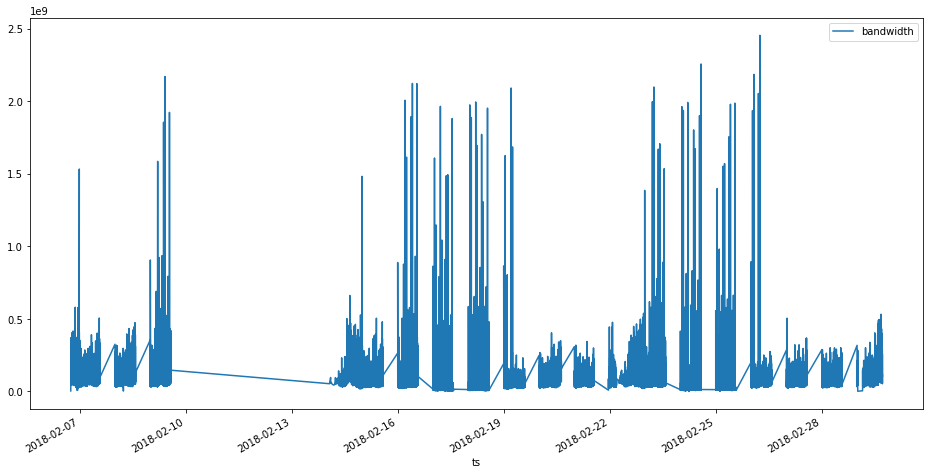

In [78]:
fig, ax = plt.subplots()
bw.plot(ax = ax);

In [ ]:
from pandas.plotting import autocorrelation_plot
fig,ax = plt.subplots(figsize=(12, 6))
autocorrelation_plot(bw.loc[:, 'bandwidth'], ax=ax)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


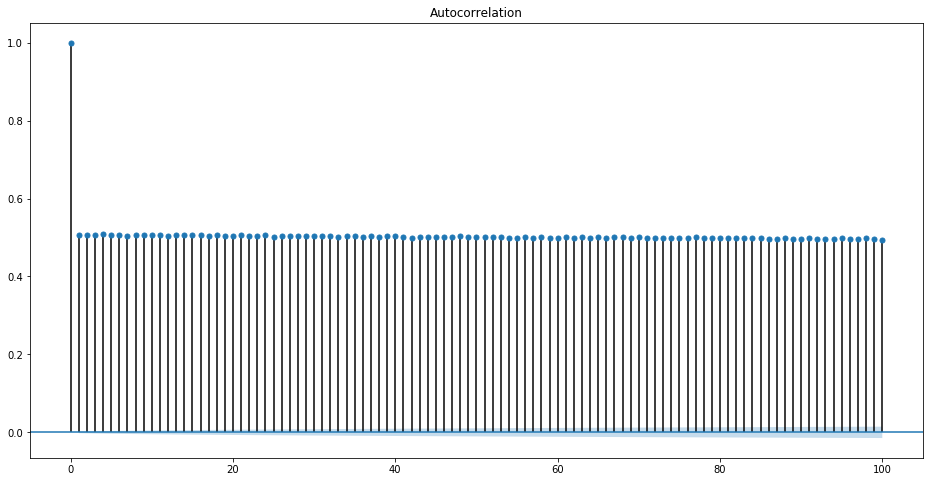

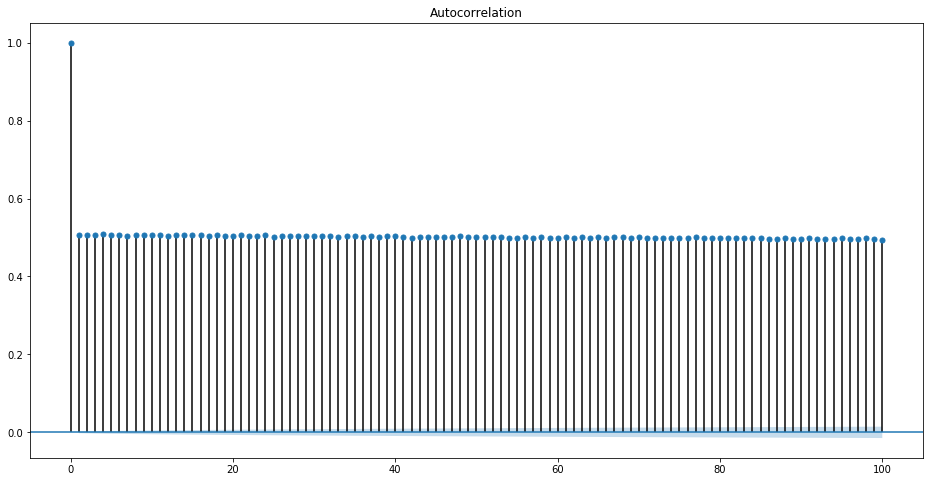

In [102]:
# Make an autocorrelation plot with statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

fig,ax = plt.subplots()
plot_acf(bw.loc[:, 'bandwidth'], lags=100, ax=ax)

In [ ]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

fig,ax = plt.subplots()
plot_pacf(bw.loc[:, 'bandwidth'], lags=100, ax=ax)

In [ ]:
five_day_mean = pd.rolling_mean(bw, window=5, min_periods=2, center=True)
ten_day_mean = pd.rolling_mean(bw, window=10, min_periods=5, center=True)

In [ ]:
print(five_day_mean.mean())
print(ten_day_mean.mean())

In [ ]:
fig, ax = plt.subplots()
bw.plot(ax = ax);
five_day_mean.plot(ax=ax)
ten_day_mean.plot(ax=ax);